In [1]:
# 先不取平均 看一看能否说明问题
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

# 设置全局字体为Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
# 读取xyz数据
root = r'C:\Users\81004\Desktop\las_paper\ana_data\1800'
file_name =  "cry_2000p_origin.lmp"
file_path = os.path.join(root,file_name)

start_frame = 0
end_frame = 1999
step_frame = 2
###########

# 要分析的元素
ana_element = ['Si','O','Al']
# lmp对应的值
dic_charge = {2.4:'Si', -1.2:'O', 1.8:'Al', 0.6:'Li'}
# 画出分布的元素
draw_element = ['O']
set_cutoff = 4.0

In [3]:
# 先按照要求读取所有的lmp数据
# 每一个原子的信息
class Atom:
    def __init__(self, id0=None, type0=None, q=None, x=None, y=None, z=None, 
                 vx=None, vy=None, vz=None, fx=None, fy=None, fz=None, 
                 c_ke_atom=None, c_pe_atom=None, v_e_total=None, frame=None, q4=None,q6=None,dis=None):
        self.id = int(id0)
        self.type = str(type0)
        self.x = x
        self.y = y
        self.z = z
        self.q = q
        self.vx = vx
        self.vy = vy
        self.vz = vz
        self.fx = fx
        self.fy = fy
        self.fz = fz
        self.c_ke_atom = c_ke_atom
        self.c_pe_atom = c_pe_atom
        self.v_e_total = v_e_total
        self.q4 = q4
        self.q6 = q6
        self.dis = dis
        self.frame = frame
    def print_info(self):
        print(f'id:{int(self.id)}, type:{self.type}, x:{self.x}, y:{self.y}, z:{self.z}, q:{self.q}')
        print(f'vx:{self.vx}, vy:{self.vy}, vz:{self.vz}, fx:{self.fx}, fy:{self.fy}, fz:{self.fz}')
        print(f'E_total:{self.v_e_total}, E_kinetic:{self.c_ke_atom}, E_potential:{self.c_pe_atom}')
        print(f'q4:{self.q4} dis:{self.q6} q6:{self.dis} frame:{self.frame}')

In [4]:
def read_lmp(file_path):
    # 所有信息储存的总列表
    list_all_frames = []
    x_min,x_max,y_min,y_max,z_min,z_max = None,None,None, None,None,None
    box_size = [None, None, None]
    num_atom = None
    len_per_frame = None
    # 第一次打开,是看一下基本数据：
    with open(file_path,'r') as f_open:
        # 前三行都不要
        for i in range(3): 
            f_open.readline()
        # 第四行是Number
        num_atom = int(f_open.readline())
        # 定义一页的行数
        len_per_frame = num_atom + 9  
        # 第五行不要
        f_open.readline()
        # 存储range范围
        temp_range_list = []
        for i in range(3): 
            temp_min,temp_max = f_open.readline().split()
            temp_range_list.append(temp_min)
            temp_range_list.append(temp_max)
        # 将字符串转换为浮点数并直接赋值给变量
        x_min, x_max, y_min, y_max, z_min, z_max = [float(i) for i in temp_range_list]
    print(f'Num of atom: {num_atom}')
    print(f'X range: {x_min}  {x_max}')
    print(f'Y range: {y_min}  {y_max}')
    print(f'Z range: {z_min}  {z_max}\n')
    
    # 开始读取文件
    f_open = open(file_path,'r')
    # 记录当前行数
    count_row = 0
    for i_frame in range(start_frame, end_frame, step_frame):
        if i_frame%50==0:
            print(f'Now is reading frame {i_frame}')
        list_frame = []
        # 先判断下是不是我要的这页
        now_frame_count = len_per_frame*i_frame
        # 如果不是同一页，则跳过这一页,再继续空读
        while count_row!=now_frame_count:
            # print(f'Now:{now_frame_count}  count:{count_row}')
            count_row+=len_per_frame
            for i in range(len_per_frame):
                f_open.readline()
        # 如果是同一页，那么就开始读取数据
        else:
            # print(f'Now:{now_frame_count}  count:{count_row}')
            # 首先就是跳过表头的9行
            # for i in range(9):
            #     f_open.readline()
            # 读取表头九行的数据
            f_open.readline()
            time_step = int(f_open.readline())
            f_open.readline()
            atom_num = float(f_open.readline())
            f_open.readline()
            x_low,x_high = f_open.readline().split()
            y_low,y_high = f_open.readline().split()
            z_low,z_high = f_open.readline().split()
            f_open.readline()
            x_low,x_high,y_low,y_high,z_low,z_high = float(x_low),float(x_high),float(y_low),float(y_high),float(z_low),float(z_high)
            dic_system = {'timestep':time_step, 
                         'num_atoms':atom_num,
                          'x_low':x_low,'x_high':x_high,
                          'y_low':y_low,'y_high':y_high,
                          'z_low':z_low,'z_high':z_high,
                         }
            # 再读取其余的数据
            for j_row in range(num_atom):
                temp_data = f_open.readline().split()
                id0, type0, q, x, y, z, vx, vy, vz, fx, fy, fz, c_ke_atom, c_pe_atom, v_e_total = [float(i) for i in temp_data]
                #print(id0, type0, q, x, y, z)
                # 类型转换回 str
                type0 = dic_charge[q]
                temp_atom = Atom(id0, type0, q, x, y, z, vx, vy, vz, fx, fy, fz, c_ke_atom, c_pe_atom, v_e_total,i_frame)
                list_frame.append(temp_atom)
            # 这一页读取完了,首先是对原子的id排序
            list_frame = sorted(list_frame, key = lambda Atom:Atom.id)
            # 再存入信息帧中
            frame_data = {
                "atom_data":list_frame,
                'system_info':dic_system
            }
            list_all_frames.append(frame_data)
            count_row+=len_per_frame
         
    # 关闭文件
    print('文件读取完毕！')
    f_open.close()
    return list_all_frames
def read_xyz_frames(file_path):
    frames = []
    current_frame = None

    with open(file_path, 'r') as file:
        lines = file.readlines()
        line_index = 0

        while line_index < len(lines):
            line = lines[line_index].strip()

            if line.isdigit():
                # 读取原子数
                if current_frame:
                    frames.append(current_frame)
                num_atoms = int(line)
                current_frame = {"num_atoms": num_atoms, "atoms": []}
                line_index += 2  # 跳过标题行 "Atoms"
            else:
                # 读取原子坐标
                if current_frame:
                    atom_data = line.split()
                    if len(atom_data) == 4:
                        element, x, y, z = atom_data
                        current_frame["atoms"].append({
                            "element": element,
                            "x": float(x),
                            "y": float(y),
                            "z": float(z)
                        })
                line_index += 1

        if current_frame:
            frames.append(current_frame)
    print('文件读取完毕！')
    return frames

In [5]:
file_type = file_path.split('\\')[-1].split('.')[-1]
frames = []
if file_type=='lmp':
    print('输入文件为lmp格式！')
    frames = read_lmp(file_path)   
elif file_type=='xyz':
    frames = read_xyz_frames(file_path)
    # 找出最大的x、y和z值
    max_x = max([max(frame["atoms"], key=lambda atom: atom["x"])["x"] for frame in frames])
    max_y = max([max(frame["atoms"], key=lambda atom: atom["y"])["y"] for frame in frames])
    max_z = max([max(frame["atoms"], key=lambda atom: atom["z"])["z"] for frame in frames])
    print("Maximum X value:", max_x)
    print("Maximum Y value:", max_y)
    print("Maximum Z value:", max_z)
else:
    print('输入文件有误！')

输入文件为lmp格式！
Num of atom: 6006
X range: -0.05780681678287891  126.29042044531153
Y range: -0.02520293888203895  55.06080293887457
Z range: -0.005242346471363568  11.452942346473058

Now is reading frame 0
Now is reading frame 50
Now is reading frame 100
Now is reading frame 150
Now is reading frame 200
Now is reading frame 250
Now is reading frame 300
Now is reading frame 350
Now is reading frame 400
Now is reading frame 450
Now is reading frame 500
Now is reading frame 550
Now is reading frame 600
Now is reading frame 650
Now is reading frame 700
Now is reading frame 750
Now is reading frame 800
Now is reading frame 850
Now is reading frame 900
Now is reading frame 950
Now is reading frame 1000
Now is reading frame 1050
Now is reading frame 1100
Now is reading frame 1150
Now is reading frame 1200
Now is reading frame 1250
Now is reading frame 1300
Now is reading frame 1350
Now is reading frame 1400
Now is reading frame 1450
Now is reading frame 1500
Now is reading frame 1550
Now is rea

In [6]:
frames[0]['atom_data'][0].print_info()
frames[20]['atom_data'][-1].print_info()
frames[0]['system_info']

id:1, type:O, x:7.88983, y:16.6921, z:10.3636, q:-1.2
vx:2.33144, vy:10.1453, vz:-1.66374, fx:0.245826, fy:2.94499, fz:0.663078
E_total:-10.3838, E_kinetic:0.0921403, E_potential:-10.476
q4:None dis:None q6:None frame:0
id:6006, type:Si, x:70.5255, y:51.9162, z:5.97443, q:2.4
vx:3.19111, vy:2.57236, vz:-6.41378, fx:-1.2699, fy:-4.85206, fz:0.676741
E_total:-34.9315, E_kinetic:0.084323, E_potential:-35.0158
q4:None dis:None q6:None frame:40


{'timestep': 1000000,
 'num_atoms': 6006.0,
 'x_low': -0.05780681678287891,
 'x_high': 126.29042044531153,
 'y_low': -0.02520293888203895,
 'y_high': 55.06080293887457,
 'z_low': -0.005242346471363568,
 'z_high': 11.452942346473058}

# 使用pyscal计算Q4-Q6

In [14]:
from pyscal3 import System
from pyscal3 import Atoms

In [16]:
def cal_bop(cal_list,ana_frame):
    frames = cal_list
    temp_system = frames[ana_frame]['system_info']
    temp_frame = frames[ana_frame]['atom_data']
    len_x,len_y,len_z = temp_system['x_high'],temp_system['y_high'],temp_system['z_high']
    sys = System()
    sys.box = [[len_x,0,0],[0,len_y,0],[0,0,len_z]]
    # sys.box = [[117.413928, 0, 0], [0, 58.746064, 0], [0, 0, 11.158]]
    # 将list转为字典 取出我们要分析的元素 
    ana_atom_list = []
    atom_xyz = []
    for i_atom in temp_frame:
        if i_atom.type in ana_element: 
            atom_xyz.append([i_atom.x,i_atom.y,i_atom.z])
            ana_atom_list.append(i_atom)
    print(np.array(atom_xyz).shape)
    # 转换元素格式
    adict = {"positions": np.array(atom_xyz, dtype=object)}
    atoms = Atoms(adict)
    # print(atoms.species)
    # print(atoms.positions)
    # 实例化
    sys.atoms = atoms
    # 这是pyscal3的Adaptive cutoff methods
    sys.find.neighbors(method='cutoff', cutoff='adaptive', padding=1.5)
    coordination = [len(sys.atoms.neighbors.index[x]) for x in range(sys.natoms)]
    #################
    nos, counts = np.unique(coordination, return_counts=True)
    plt.bar(nos, counts, color="#AD1457")
    plt.ylabel("density")
    plt.xlabel("coordination number")
    plt.title("Cutoff adaptive method")
    # 计算q4和q6 然后采用均值的方法
    # q4_q6_list = sys.calculate.steinhardt_parameter([4,6], averaged=True)
    q4_q6_list = sys.calculate.steinhardt_parameter([4,6], averaged=True)
    print(f'Mean_q4:{sum(q4_q6_list[0])/len(q4_q6_list[0])}')
    return ana_atom_list, q4_q6_list,[len_x,len_y,len_z]

# 相关函数

In [19]:
def cal_ppp_dis_object(boxsize,point1,point2):
    i_1 = np.array([point1.x,point1.y,point1.z])
    j_1 = np.array([point2.x,point2.y,point2.z])
    boxsize = np.array(boxsize)
    # 计算
    delta = i_1-j_1
    delta = delta - np.round(delta / boxsize) * boxsize
    distance = np.linalg.norm(delta)
    return distance

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
    
def draw_q4(data_temp,critical_q4,label_list,title_name):
    # 从 data_list 中提取 x、y、q4 和 q6 数据
    #########
    x_data = [item.x for item in data_temp]
    y_data = [item.y for item in data_temp]
    q4_data = [item.q4 for item in data_temp]
    q6_data = [item.q6 for item in data_temp]
    # 创建二维分布图
    plt.figure(figsize=(10, 6) ,dpi=80)
    mean_q4 = sum(q4_data)/len(q4_data)
    num_max_q4 = len([i for i in q4_data if i>critical_q4])
    print('Mean q4:' + str(round(mean_q4,4))+' Percentage of Q4 > 0.18:'+ str(round(num_max_q4/len(q4_data)*100,2))+'%')
    
    ###########################################
    # 定义viridis色谱的底端绿色渐变
    
    viridis_cmap = plt.get_cmap('viridis')
    
    # 生成顶端橙黄色的渐变，使用非常短的橙色段
    orange_yellow = ['#ffea00', '#ff7f0e']  # 橙色到黄色的 HEX 色码，顺序调整为黄色到橙色
    orange_yellow_cmap = LinearSegmentedColormap.from_list('orange_yellow', orange_yellow, N=8)
    
    # 合并两个色谱，创建自定义色谱
    colors = np.vstack((viridis_cmap(np.linspace(0, 1, 128)),
                        orange_yellow_cmap(np.linspace(0, 1, 8))))  # 使用非常短的橙色段
    custom_cmap = ListedColormap(colors)
    ###########################################################
    name_x = file_path.split('\\')[-1]
    # 绘制 q4 在 x-y 平面上的二维分布图
    title_name = title_name
    plt.title(title_name , fontsize=15, fontweight='bold') 
    
    ################
    plt.scatter(x_data, y_data, s=15, c=q4_data, cmap=custom_cmap, marker='o',vmin=0.05, vmax=critical_q4)
    plt.colorbar()
    plt.scatter(label_list[0],label_list[1],color='blue')
    # plt.title('O' , fontsize=15, fontweight='bold')  
    plt.xlabel('X-axis ', fontsize=15, fontweight='bold')  # 设置 x 轴标签字体大小和加粗
    plt.ylabel('Y-axis', fontsize=15, fontweight='bold')  # 设置 y 轴标签字体大小和加粗
    
    # 设置 x 轴刻度值的字体大小、颜色和加粗
    plt.xticks(range(0, int(max(x_data)) + 1, 10), fontsize=12, fontweight='bold')
    # 设置 y 轴刻度值的字体大小、颜色和加粗
    plt.yticks(fontsize=12, fontweight='bold')
    # plt.legend()
    plt.show()

In [23]:
def filter_bop(temp_list):
    # 第一次是去除性地筛选
    filter_list = []
    for i_atom in temp_list:
        i_q4 = i_atom.q4
        # 如果原子不是q4>0.18
        if i_q4<critical_q4:
            filter_list.append(i_atom)
            continue
        #  如果大于0.18
        else:   
            count_cry = 0
            for j_atom in temp_list:
                j_q4 = j_atom.q4
                if cal_ppp_dis_object(boxsize,i_atom,j_atom)<critical_dis and j_q4>critical_q4 :
                    count_cry+=1
            if count_cry<critical_neibor_cry:
                rand_num = np.random.uniform(0.12, 0.18)
                i_atom.q4 = rand_num
            #elif count_cry>=critical_neibor_cry and i_q4<critical_q4:
                #i_q4 = critical_q4+0.01
            filter_list.append(i_atom)
    # 第二次是确定性地添加
    filter_list_1 = []
    for i_atom in filter_list:
        i_q4 = i_atom.q4
        # 如果原子不是q4>0.18
        if i_q4>critical_q4:
            filter_list_1.append(i_atom)
            continue
        #  如果大于0.18
        else:   
            count_cry = 0
            for j_atom in filter_list:
                j_q4 = j_atom.q4
                if cal_ppp_dis_object(boxsize,i_atom,j_atom)<critical_dis and j_q4>critical_q4 :
                    count_cry+=1
            if count_cry>critical_neibor_cry:
                rand_num = np.random.uniform(0.181, 0.25)
                i_atom.q4 = rand_num
            #elif count_cry>=critical_neibor_cry and i_q4<critical_q4:
                #i_q4 = critical_q4+0.01
            filter_list_1.append(i_atom)
    return  filter_list_1



In [25]:
print(f'共有{len(frames)}帧')

共有1000帧


# 绘制BOP的帧数

In [137]:
num_ana = np.arange(0,999,10)
print(num_ana)
#num_ana[-1] = 0
#print(num_ana)
len(num_ana)

[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530
 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710
 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890
 900 910 920 930 940 950 960 970 980 990]


100

In [9]:
np.arange(42,3,-1)

array([42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26,
       25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,
        8,  7,  6,  5,  4])

In [15]:
time = np.arange(42,3,-1)[:25]

In [19]:
import matplotlib.pyplot as plt

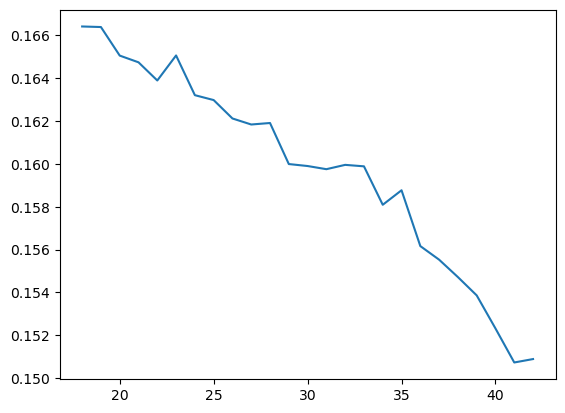

In [21]:
plt.plot(time,q4_list)

In [1]:
##
q4_list = [
0.1508897106405453
,0.1507302132585421
,0.15231814890095546
,0.15386293492582181
,0.15471687836785286
,0.15552993574409688
,0.15616440658384445
,0.1587704698684236
,0.15809295874426996
,0.1598882077659182
,0.1599568654594105
,0.1597549691131812
,0.1599025924018163
,0.15999470369271024
,0.1619111719430786
,0.16184108803561853
,0.16212280840766896
,0.16298212688791314
,0.16321081419149136
,0.16506477547270104
,0.16389632748413716
,0.16474480687199355
,0.16505853496578846
,0.16639189579529196
,0.16641798982445755
]

In [139]:
# 需要分析的帧数  80帧
num_ana = np.arange(0,999,10)
### 
ana_frame_num_list = num_ana
All_ana_frame = [None]*len(num_ana)  

# 不使用KNN过滤

Now is analyzing frame:0.
(5148, 3)
Mean_q4:0.1554714906409619
运行时间：91.782669 秒
Now is analyzing frame:10.
(5148, 3)
Mean_q4:0.15575299726455621
运行时间：91.661306 秒
Now is analyzing frame:20.
(5148, 3)
Mean_q4:0.15665544749553093
运行时间：93.973025 秒
Now is analyzing frame:30.
(5148, 3)
Mean_q4:0.15732816372794878
运行时间：91.127887 秒
Now is analyzing frame:40.
(5148, 3)
Mean_q4:0.15793850210826393
运行时间：91.400827 秒
Now is analyzing frame:50.
(5148, 3)
Mean_q4:0.15782730882986448
运行时间：95.219576 秒
Now is analyzing frame:60.
(5148, 3)
Mean_q4:0.1579941418225014
运行时间：95.575294 秒
Now is analyzing frame:70.
(5148, 3)
Mean_q4:0.15657866715849705
运行时间：94.045839 秒
Now is analyzing frame:80.
(5148, 3)
Mean_q4:0.1603838666300896
运行时间：94.491503 秒
Now is analyzing frame:90.
(5148, 3)
Mean_q4:0.15757322115874192
运行时间：93.978625 秒
Now is analyzing frame:100.
(5148, 3)
Mean_q4:0.16066112618209916
运行时间：93.824326 秒
Now is analyzing frame:110.
(5148, 3)
Mean_q4:0.16070282913778303
运行时间：90.616250 秒
Now is analyzing f

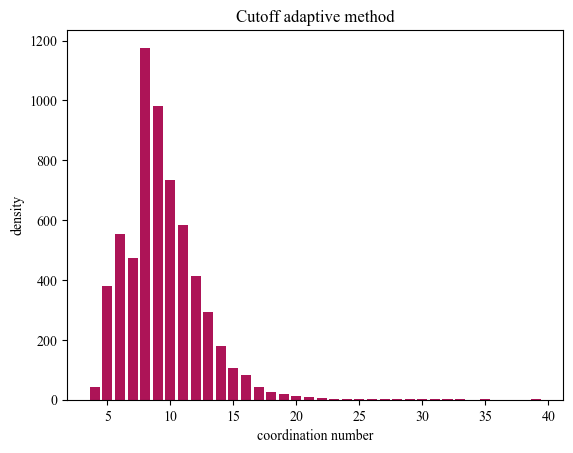

In [141]:
# 记录开始时间
import time
start_time = time.time()  
for i_index,i_num in enumerate(ana_frame_num_list):
    print(f'Now is analyzing frame:{i_num}.')
    temp_time = time.time() 
    temp_frame_list = frames[i_num]['atom_data']
    temp_frame_list = [i for i in temp_frame_list if i.type!='Li']
    origin_ana_atom_list, origin_q4_q6_list,box_len = cal_bop(frames,i_num)
    ####
    # 给当下原子新实例 赋值
    All_atom_list = [None]*len(temp_frame_list)
    for j_index,i_atom in enumerate(temp_frame_list):
        i_id = i_atom.id
        j_id = origin_ana_atom_list[j_index].id
        ######
        if i_id!=j_id:
            print('Error')
            5/0
        else:
            i_atom.q4 = origin_q4_q6_list[0][j_index]
            i_atom.q6 = origin_q4_q6_list[1][j_index]
    # BOP分析
    #draw_element = ['Si','Al','O'] 
    #draw_ele_list = All_atom_list
    ###### 可视化 
    # critical_q4 = 0.18  
    # cry_xyz = [[i.x for i in draw_ele_list if i.q4>critical_q4],[i.y for i in draw_ele_list if i.q4>critical_q4]]
    # draw_q4(draw_ele_list, critical_q4, cry_xyz,'Crystal points in LAS(without KNN)')
    # ######## KNN 细化分析
    # # 就不用再使用KNN过滤了
    
    # # 遍历每一个原子 根据
    # critical_dis = 5.0
    # critical_q4 = 0.18
    # critical_neibor_cry = 18
    # boxsize = box_len
    # #  
    # draw_knn_q4_list = filter_bop(draw_ele_list)
    # cry_point = [[i.x for i in draw_knn_q4_list if i.q4>critical_q4],[i.y for i in draw_knn_q4_list if i.q4>critical_q4]]
    # draw_q4(draw_knn_q4_list,0.18,cry_point,'Crystal points of LAS (After KNN)')
    # ######### 计算距离 
    # cry_atom = [i for i in draw_knn_q4_list if i.q4>critical_q4]
    # draw_knn_q4q6dis_list = []
    # for i in draw_knn_q4_list:
    #     i.dis = 100
    #     draw_knn_q4q6dis_list.append(i)
    # # 计算距离 
    # for i_atom in draw_knn_q4q6dis_list:
    #     for j_atom in cry_atom:
    #         # 算距离 
    #         dis = cal_ppp_dis_object(boxsize,i_atom,j_atom)
    #         if dis<i_atom.dis:
    #             i_atom.dis = dis
    #######
    All_ana_frame[i_index] = temp_frame_list
    temp_time1 = time.time()
    print(f"运行时间：{(temp_time1 - temp_time):.6f} 秒")
    
end_time = time.time()  # 记录结束时间
print(f"总的运行时间：{(end_time - start_time):.6f} 秒")

In [144]:
print(f'len frame: {len(All_ana_frame)}')
All_ana_frame[-1][0].print_info()

len frame: 100
id:1, type:O, x:8.15476, y:25.7733, z:7.38119, q:-1.2
vx:-1.99642, vy:-11.4372, vz:2.76146, fx:-2.8878, fy:-0.657136, fz:0.703097
E_total:-7.69572, E_kinetic:0.118083, E_potential:-7.81381
q4:0.12810669692443688 dis:0.0725020624760078 q6:None frame:1980


In [143]:
# 数据保存
save_name  = '1800k_0_999—10_frame.npy'
save_path = os.path.join(root,save_name)
np.save(save_path,All_ana_frame)

In [57]:
All_ana_frame[0][1].print_info()

id:2, type:O, x:10.028, y:10.2106, z:8.62202, q:-1.2
vx:13.8807, vy:9.72395, vz:-4.04433, fx:1.42696, fy:-0.120538, fz:-0.0908945
E_total:-9.30688, E_kinetic:0.251706, E_potential:-9.55859
q4:0.14808672346743165 dis:0.14808672346743165 q6:None frame:1000


# 分析析晶过程

In [147]:
count_o = 0
count_si = 0
count_al = 0
for i in All_ana_frame[0]:
    if i.type=='Si':
        count_si+=1
    elif i.type=='O':
        count_o+=1
    elif i.type=='Al':
        count_al+=1
print(count_o,count_si,count_al)

3432 858 858


In [162]:
len(All_ana_frame)

100

In [285]:
# 找到目标原子
index = None
atom_xyz = [86.403 ,  37.028 ,     8.074]
for j in All_ana_frame[49:51]:
    for num,i in enumerate(j):
        if i.type=='Si' and abs(i.x-atom_xyz[0])<1 and abs(i.y-atom_xyz[1])<1 and abs(i.z-atom_xyz[2])<1:
            i.print_info()
            index=num  
print(index)

id:4840, type:Si, x:86.7289, y:37.0502, z:7.99465, q:2.4
vx:2.3553, vy:0.670079, vz:-2.71426, fx:0.753584, fy:-1.91405, fz:-4.83899
E_total:-32.0173, E_kinetic:0.0194499, E_potential:-32.0367
q4:0.18898430899768956 dis:0.12160650097635468 q6:None frame:1000
4125


In [287]:
box_len

[126.2737862980753, 55.053550690468256, 11.451433839912514]

In [289]:
All_ana_frame[0][index].print_info()

id:4840, type:Si, x:82.379, y:37.125, z:3.47911, q:2.4
vx:-6.6913, vy:-11.6486, vz:10.5355, fx:2.55372, fy:-0.325264, fz:-0.541444
E_total:-32.0246, E_kinetic:0.4242, E_potential:-32.4488
q4:0.17781440878526464 dis:0.06984322472723903 q6:None frame:0


In [291]:
All_ana_frame[0][index].print_info()

id:4840, type:Si, x:82.379, y:37.125, z:3.47911, q:2.4
vx:-6.6913, vy:-11.6486, vz:10.5355, fx:2.55372, fy:-0.325264, fz:-0.541444
E_total:-32.0246, E_kinetic:0.4242, E_potential:-32.4488
q4:0.17781440878526464 dis:0.06984322472723903 q6:None frame:0


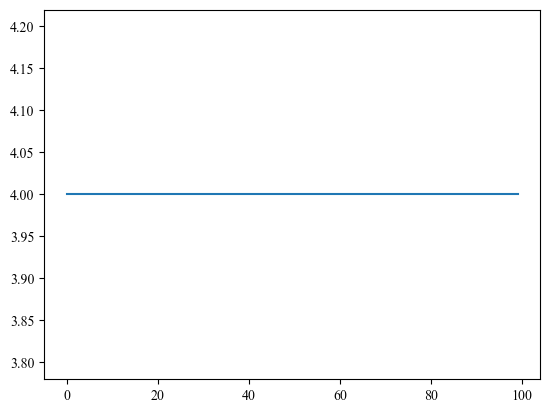

In [293]:
# 找到与这个原子最近的四个O原子 然后分析他们的Q4 可能每次的原子不一样  因此存下来
index = index
###
neibor_list = [[] for _ in range(len(All_ana_frame))]
for i_num,i_frame in enumerate(All_ana_frame):
    temp_atom = i_frame[index]
    for j_atom in i_frame:
        if j_atom.type == 'O':
            dis = cal_ppp_dis_object(box_len,temp_atom,j_atom)
            if 1.0<dis<2.5:
                neibor_list[i_num].append(j_atom)
# 
# 求出四周原子的Q4
q4_neibor = []
for i in neibor_list:
    q4 = sum([j.q4 for j in i])/len(i)
    q4_neibor.append(q4)
# 
x = range(len(All_ana_frame))
y = [len(i) for i in neibor_list]
plt.plot(x,y)

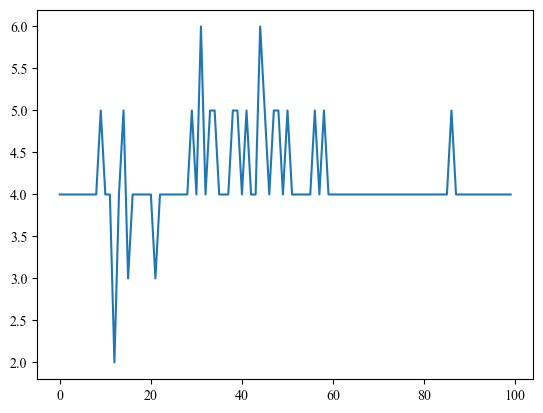

In [294]:
# 找到与这个原子最近的 NF 然后分析他们的Q4 可能每次的原子不一样  因此存下来
si1_neibor = [[] for _ in range(len(All_ana_frame))]
for i_num,i_frame in enumerate(All_ana_frame):
    temp_atom = i_frame[index]
    for j_atom in i_frame:
        if j_atom.type in ['Si','Al']:
            dis = cal_ppp_dis_object(box_len,temp_atom,j_atom)
            if 2.5<dis<4.0:
                si1_neibor[i_num].append(j_atom)
# 
# 求出四周原子的Q4
si1_q4 = []
for i in si1_neibor:
    q4 = sum([j.q4 for j in i])/len(i)
    si1_q4.append(q4)
#
x = range(len(All_ana_frame))
y = [len(i) for i in si1_neibor]
plt.plot(x,y)

In [353]:
sum([len(i) for i in si1_neibor])/100

4.15

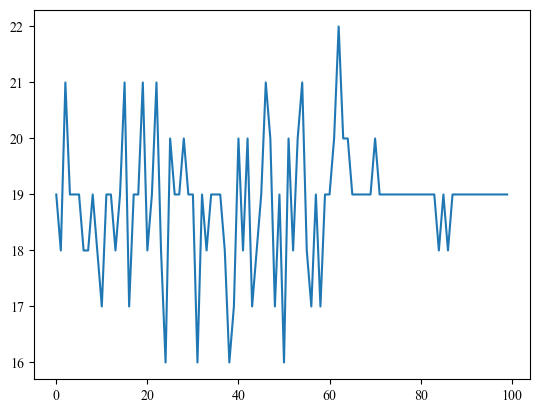

In [296]:
# 找到与这个原子最近的四个O原子 然后分析他们的Q4 可能每次的原子不一样  因此存下来
si2_neibor_list = [[] for _ in range(len(All_ana_frame))]
for i_num,i_frame in enumerate(All_ana_frame):
    temp_atom = i_frame[index]
    for j_atom in i_frame:
        if j_atom.type in ['Si','Al']:
            dis = cal_ppp_dis_object(box_len,temp_atom,j_atom)
            if 4.0<dis<6.5:
                si2_neibor_list[i_num].append(j_atom)
# 
# 求出四周原子的Q4
si2_q4 = []
for i in si2_neibor_list:
    q4 = sum([j.q4 for j in i])/len(i)
    si2_q4.append(q4)
# 
x = range(len(All_ana_frame))
y = [len(i) for i in si2_neibor_list]
plt.plot(x,y)

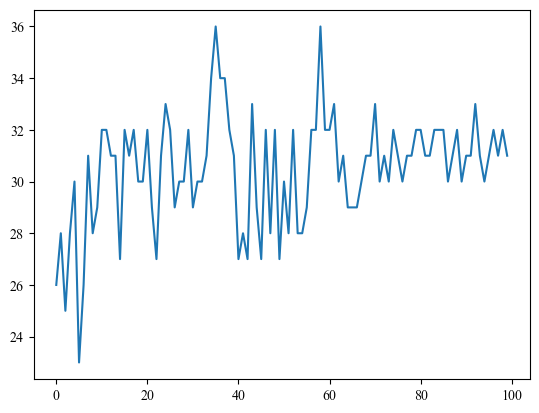

In [297]:
# 找到与这个原子最近的四个O原子 然后分析他们的Q4 可能每次的原子不一样  因此存下来
si3_neibor_list = [[] for _ in range(len(All_ana_frame))]
for i_num,i_frame in enumerate(All_ana_frame):
    temp_atom = i_frame[index]
    for j_atom in i_frame:
        if j_atom.type in ['Si','Al']:
            dis = cal_ppp_dis_object(box_len,temp_atom,j_atom)
            if 6.5<dis<9:
                si3_neibor_list[i_num].append(j_atom)
# 
# 求出四周原子的Q4
si3_q4 = []
for i in si3_neibor_list:
    q4 = sum([j.q4 for j in i])/len(i)
    si3_q4.append(q4)
# 
x = range(len(All_ana_frame))
y = [len(i) for i in si3_neibor_list]
plt.plot(x,y)

In [299]:
q4_list = [None]*len(All_ana_frame)
for i,j in enumerate(All_ana_frame):
    q4 = j[index].q4
    q4_list[i]=q4

(40.0, 80.0)

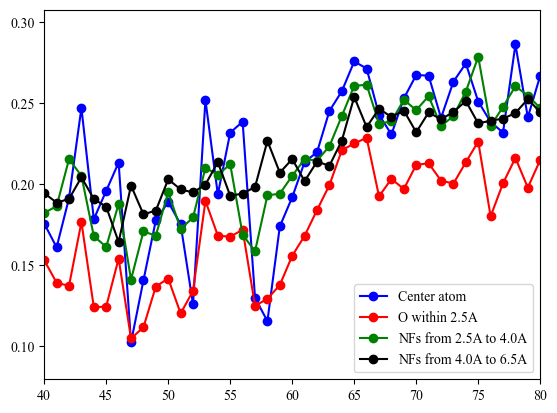

In [317]:
x = np.array(range(len(q4_list)))
y0 = q4_list
y1 = q4_neibor
y2 = si1_q4
y3 = si2_q4
y4 = si3_q4
plt.plot(x,y0,c='blue', marker='o',label = 'Center atom')
plt.plot(x,y1,c='red', marker='o',label='O within 2.5A')
plt.plot(x,y2,c='green', marker='o',label='NFs from 2.5A to 4.0A')
plt.plot(x,y3,c='black', marker='o',label='NFs from 4.0A to 6.5A')
# plt.plot(x,y4,c='purple',label='Si/Al from 6.5A to 9.0A')
plt.legend()
#plt.xticks(np.arange(0, 80, 2))
plt.xlim(40,80)
#plt.grid(True)

In [339]:
# 数据保存
x_t = np.array(range(len(q4_list)))*80/100
save_name  = '1800k_si_q4.txt'
save_path = os.path.join(root,save_name)
save_list = np.array([x_t,y0,y1,y2,y3]).T
np.savetxt(save_path,save_list)

In [323]:
x_t

array([ 0. ,  0.8,  1.6,  2.4,  3.2,  4. ,  4.8,  5.6,  6.4,  7.2,  8. ,
        8.8,  9.6, 10.4, 11.2, 12. , 12.8, 13.6, 14.4, 15.2, 16. , 16.8,
       17.6, 18.4, 19.2, 20. , 20.8, 21.6, 22.4, 23.2, 24. , 24.8, 25.6,
       26.4, 27.2, 28. , 28.8, 29.6, 30.4, 31.2, 32. , 32.8, 33.6, 34.4,
       35.2, 36. , 36.8, 37.6, 38.4, 39.2, 40. , 40.8, 41.6, 42.4, 43.2,
       44. , 44.8, 45.6, 46.4, 47.2, 48. , 48.8, 49.6, 50.4, 51.2, 52. ,
       52.8, 53.6, 54.4, 55.2, 56. , 56.8, 57.6, 58.4, 59.2, 60. , 60.8,
       61.6, 62.4, 63.2, 64. , 64.8, 65.6, 66.4, 67.2, 68. , 68.8, 69.6,
       70.4, 71.2, 72. , 72.8, 73.6, 74.4, 75.2, 76. , 76.8, 77.6, 78.4,
       79.2])

In [345]:
600*80/1000

48.0

In [ ]:
# 虽然这个数据可以说明 析晶存在着附近结构的同步的 但是单个原子也会造成这种结果
# 如果析晶够快的话 

In [ ]:
# 1ns是 0.56

In [1034]:
# # 找一个在中间析晶的原子
# for j_atom in range(len(All_ana_frame[0])):
#     count_1,count_2 = 0,0
#     for i_frame in range(200):
#         # 找一个在中间析晶的
#         temp_atom = All_ana_frame[i_frame][j_atom]
#         if temp_atom.type in ['Si','Al']:
#             if temp_atom.q4<0.16 and i_frame<101:
#                 count_1+=1
#             elif temp_atom.q4>0.170 and i_frame>101:
#                 count_2+=1
#     if 4<abs(count_1-count_2)<10 and temp_atom.type != 'O':
#         temp_atom.print_info()

In [243]:
print("center vs first neibors(O):", pearson_correlation(q4_list, q4_neibor))
print("center vs first neibors(Si,Al):", pearson_correlation(q4_list, si1_q4))
print("center vs third neibors(Si,Al)", pearson_correlation(q4_list, si2_q4))
print("center vs third neibors(Si,Al)", pearson_correlation(q4_list, si3_q4))

center vs first neibors(O): 0.9463236125189224
center vs first neibors(Si,Al): 0.8957788986821782
center vs third neibors(Si,Al) 0.817079367916237
center vs third neibors(Si,Al) 0.8144899740371453


In [1036]:
print( pearson_correlation(q4_list, q4_neibor))
print(pearson_correlation(q4_list, sial_q4))
print( pearson_correlation(q4_list, si2_q4))
print(pearson_correlation(q4_list, si3_q4))

0.23580784767484128
0.1963711276357817
0.2348831929713969
0.2013132383012107


# 趋势的相关性

In [237]:
import numpy as np

def pearson_correlation(x, y):
    x = np.array(x)
    y = np.array(y)
    
    if len(x) != len(y):
        raise ValueError("输入的两个数组长度必须相同。")
    
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sqrt(np.sum((x - x_mean) ** 2)) * np.sqrt(np.sum((y - y_mean) ** 2))
    
    if denominator == 0:
        return 0.0  # 避免除以零
    
    return numerator / denominator

# 示例数据
x = [1, 2, 3, 4, 5]
y = [2, 4, 6, 8, 10]

r = pearson_correlation(x, y)
print("皮尔逊相关系数 r =", r)


皮尔逊相关系数 r = 0.9999999999999998


In [938]:
print("center vs first neibors(O):", pearson_correlation(q4_list, q4_neibor))
print("center vs first neibors(Si,Al):", pearson_correlation(q4_list, sial_q4))
print("center vs third neibors(Si,Al)", pearson_correlation(q4_list, si2_q4))
print("center vs third neibors(Si,Al)", pearson_correlation(q4_list, si3_q4))

center vs first neibors(O): 0.37172452977622655
center vs first neibors(Si,Al): 0.4340887744270329
center vs third neibors(Si,Al) 0.44343774830411986
center vs third neibors(Si,Al) 0.2417506676256481


In [940]:
print( pearson_correlation(q4_list, q4_neibor))
print(pearson_correlation(q4_list, sial_q4))
print( pearson_correlation(q4_list, si2_q4))
print(pearson_correlation(q4_list, si3_q4))

0.37172452977622655
0.4340887744270329
0.44343774830411986
0.2417506676256481


center vs third neibors(Si,Al) 0.027114936377654584


# 重要数据一定要保存下来


In [58]:
# 数据保存
save_name  = '1800k_500-700_frame.npy'
save_path = os.path.join(root,save_name)
np.save(save_path,All_ana_frame)

In [34]:
data = np.load(save_path,allow_pickle=True)

In [49]:
All_ana_frame = data
All_ana_frame[-1][0].print_info()

id:1, type:O, x:6.11523, y:22.1293, z:5.17938, q:-1.2
vx:9.456, vy:-5.1557, vz:15.7035, fx:1.92409, fy:-1.47606, fz:0.789213
E_total:-10.3348, E_kinetic:0.300632, E_potential:-10.6354
q4:0.126325292764074 dis:0.126325292764074 q6:11.04555068968949 frame:1900


# 之后就是按照元素分析性质了

In [52]:
len(All_ana_frame)

20

In [58]:
All_ana_frame[1][0].print_info()

id:1, type:O, x:11.2912, y:16.6198, z:10.4151, q:-1.2
vx:-9.32494, vy:-3.57517, vz:14.1395, fx:-1.49464, fy:0.00389495, fz:-5.42587
E_total:-8.98154, E_kinetic:0.248453, E_potential:-9.22999
q4:0.1265799803778213 dis:0.1265799803778213 q6:29.692546880360396 frame:100


# 然后就是分析这一个帧数之后 附近原子的位移情况 

In [99]:
f = 870

In [101]:
80/1000*f

69.60000000000001

In [ ]:
# 

In [106]:
## 时间间隔
interval_frame = 2
# 选出固定范围内的原子
dis_range = [0.01,20]
# 选取的中心 晶体中的原子
cry_q4q6dis_ele = ['Al','Si','O']
# 选取的是 界面处的原子
interface_ele = ['Si','Al','O']

In [108]:
frames[0]['atom_data'][0].print_info()

id:1, type:O, x:7.41975, y:17.0185, z:10.7092, q:-1.2
vx:16.1999, vy:12.2911, vz:-2.56295, fx:1.13623, fy:-0.519201, fz:-0.963825
E_total:-11.9497, E_kinetic:0.34829, E_potential:-12.298
q4:0.13619546631936527 dis:0.13619546631936527 q6:38.69017367602012 frame:0


In [110]:
# 计算dis
res_dis_msd = []
for i_frame in All_ana_frame:
    for j_atom in i_frame:
        # 先确保分析的是合适位置的原子类型 和 距离范围
        if j_atom.type in interface_ele and dis_range[0]<j_atom.dis<dis_range[1]:
            # 在初始list中找到下一个时刻的原子 然后计算msd
            next_index = int(j_atom.id-1)
            num_frame = int(j_atom.frame/step_frame)
            num_next_frame = int(num_frame+interval_frame)
            atom_next = frames[num_next_frame]['atom_data'][next_index]
            # 然后计算三维距离 
            lx = frames[num_frame]['system_info']['x_high']
            ly = frames[num_frame]['system_info']['y_high']
            lz = frames[num_frame]['system_info']['z_high']
            box_size = np.array([lx,ly,lz])
            # 再次验证一下id是否相同
            if j_atom.id == atom_next.id:
                res = cal_ppp_dis_object(box_size,j_atom,atom_next)
                res_dis_msd.append([ j_atom.dis, res, j_atom.type,j_atom.q4])

In [136]:
select_ele = ['Al']
# 然后整理为dis_xy
dis_xy = [i[0] for i in res_dis_msd if i[2] in select_ele],[i[1] for i in res_dis_msd if i[2] in select_ele]
select_res = [[i[0],i[1] ] for i in res_dis_msd if i[2] in select_ele]
len(select_res)

3064

# 画出分布图

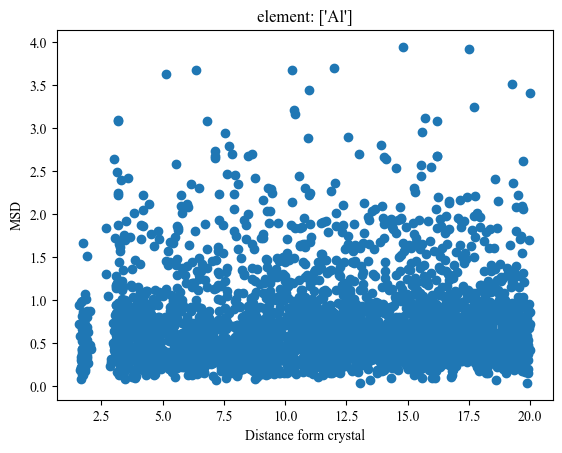

In [139]:
# 然后根据dis 会画出dis和msd的关系 做平均
x_dis = dis_xy[0]
y_msd = dis_xy[1]
plt.scatter(x_dis,y_msd)
plt.title(f'element: {select_ele}')
plt.ylabel('MSD')
plt.xlabel('Distance form crystal')
plt.show()

#  分析当下的帧数信息

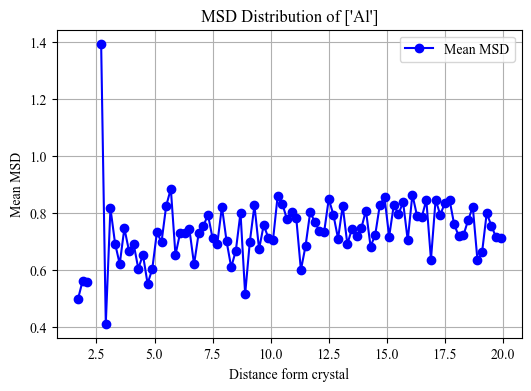

In [142]:
# 设置 bins=0.5
bin_step = 0.2
# 原始数据
data = select_res
ana_type = 'mean'
####### 'median'
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

# 转换为 numpy 数组
data = np.array(data)
dis_list = data[:, 0]  # 取 dis 值
msd_list = data[:, 1]  # 取 msd 值
bins = np.arange(0, np.max(dis_list) + bin_step, bin_step)
# 计算 msd 的均值
bin_msd_means, bin_edges, _ = binned_statistic(dis_list, msd_list, statistic=ana_type, bins=bins)

# 计算 bin 中心
bin_centers = bin_edges[:-1] + bin_step / 2
x0 = bin_centers
y0 = bin_msd_means
# 绘制分布
plt.figure(figsize=(6, 4))
plt.plot(bin_centers, bin_msd_means, marker='o', linestyle='-', color='b', label='Mean MSD')
plt.xlabel('Distance form crystal')
plt.ylabel('Mean MSD')
plt.title(f'MSD Distribution of {select_ele}')
plt.legend()
plt.grid(True)
plt.show()


In [36]:
file_name = os.path.join(root,'1800K_MSD_Al.txt')
np.savetxt(file_name, np.array([x0,y0]).T, delimiter=",", fmt="%.6f")

# Q4

In [38]:
select_ele = ['Al','O','Si']
# 然后整理为dis_xy
dis_q4 = [i[0] for i in res_dis_msd if i[2] in select_ele],[i[3] for i in res_dis_msd if i[2] in select_ele]
len(select_res)

3064

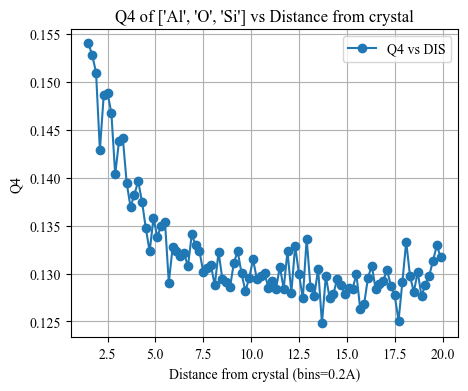

In [39]:
bin_step = 0.2
# 提取 dis 和 msd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

dis_list = np.array(dis_q4[0])
msd_list = np.array(dis_q4[1])

# 定义 bins
bins = np.arange(0, max(dis_list) + bin_step, bin_step)  # [0.0, 0.2, 0.4, ...]

# 使用 scipy 计算分箱均值（自动处理空 bins）
bin_msd_means, bin_edges, _ = binned_statistic(
    dis_list, msd_list, statistic='mean', bins=bins
)
bin_centers = bin_edges[:-1] + 0.1  # bin 中心
x1,y1 = bin_centers,bin_msd_means
# 绘制
plt.figure(figsize=(5, 4))
plt.plot(bin_centers, bin_msd_means, 'o-', label='Q4 vs DIS')
plt.xlabel(f'Distance from crystal (bins={bin_step}A)')
plt.ylabel('Q4')
plt.title(f'Q4 of {select_ele} vs Distance from crystal')
plt.grid(True)
plt.legend()
plt.show()

In [40]:
file_name = os.path.join(root,'2100K_q4_all.txt')
np.savetxt(file_name, np.array([x1,y1]).T, delimiter=",", fmt="%.6f")

# 再就是能量 速度 等的分布

In [42]:
All_ana_frame[0][0].print_info()

id:1, type:O, x:7.41975, y:17.0185, z:10.7092, q:-1.2
vx:16.1999, vy:12.2911, vz:-2.56295, fx:1.13623, fy:-0.519201, fz:-0.963825
E_total:-11.9497, E_kinetic:0.34829, E_potential:-12.298
q4:0.13619546631936527 dis:0.13619546631936527 q6:38.69017367602012 frame:0


In [43]:
## 时间间隔
interval_frame = 2
# 选出固定范围内的原子
dis_range = [0.01,20]
# 选取的中心 晶体中的原子
cry_q4q6dis_ele = ['Al','Si','O']
# 选取的是 界面处的原子
interface_ele = ['Si','Al','O']

In [44]:
# 之后就是分析 能量 和  受力 
# 
res_f_e3 = []
for i_frame in All_ana_frame:
    for j_atom in i_frame:
        # 先确保分析的是合适位置的原子类型 和 距离范围
        if j_atom.type in interface_ele and dis_range[0]<j_atom.dis<dis_range[1]:
            #   直接筛选当前原子的 能量 和 受力
            f = (j_atom.fx**2+j_atom.fy**2+j_atom.fz**2)**0.5
            res_f_e3.append([ j_atom.dis, j_atom.type, f, j_atom.c_ke_atom, j_atom.c_pe_atom, j_atom.v_e_total])

In [45]:
len(res_f_e3)

17965

In [46]:
# [dis-0 , type-1, f-2, ke-3, pe-4, total-5] 
select_num = 4

In [47]:
select_ele = ['Al','Si','O']
# 然后整理为dis_xy
dis_f = [i[0] for i in res_f_e3 if i[1] in select_ele],[i[select_num] for i in res_f_e3 if i[1] in select_ele]
len(dis_f[0])

17965

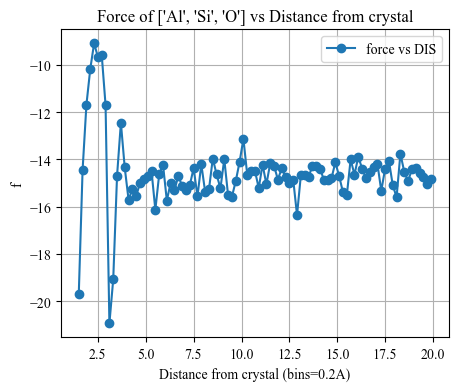

In [48]:
bin_step = 0.2
# 提取 dis 和 msd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

dis_list = np.array(dis_f[0])
msd_list = np.array(dis_f[1])

# 定义 bins
bins = np.arange(0, max(dis_list) + bin_step, bin_step)  # [0.0, 0.2, 0.4, ...]

# 使用 scipy 计算分箱均值（自动处理空 bins）
bin_msd_means, bin_edges, _ = binned_statistic(
    dis_list, msd_list, statistic='mean', bins=bins
)
bin_centers = bin_edges[:-1] + 0.1  # bin 中心
x2,y2 = bin_centers,bin_msd_means
# 绘制
plt.figure(figsize=(5, 4))
plt.plot(bin_centers, bin_msd_means, 'o-', label='force vs DIS')
plt.xlabel(f'Distance from crystal (bins={bin_step}A)')
plt.ylabel('f')
plt.title(f'Force of {select_ele} vs Distance from crystal')
# plt.xlim(0,15)
plt.grid(True)
plt.legend()
plt.show()

In [49]:
file_name = os.path.join(root,'1500K_dis_pe.txt')
np.savetxt(file_name, np.array([x2,y2]).T, delimiter=",", fmt="%.6f")

In [50]:
test_list = res_msd_dis
bin_step = 0.5
max_range = 15
# 提取数据
msd_list = np.array([x[0] for x in test_list])
dis_list = np.array([x[1] for x in test_list])

# 自定义 bins (例如: 0.0, 0.2, 0.4, ..., 2.0)
bins = np.arange(0, max_range + 0.2, bin_step)  # 0.0, 0.2, 0.4, ..., 2.0

# 计算每个 bin 的 mean 和 std
bin_indices = np.digitize(dis_list, bins)  # 每个数据点属于哪个 bin
bin_means = []
bin_stds = []
bin_centers = []

for i in range(1, len(bins)):
    mask = (bin_indices == i)
    if np.any(mask):
        bin_means.append(np.mean(msd_list[mask]))
        bin_stds.append(np.std(msd_list[mask]))
        bin_centers.append((bins[i-1] + bins[i]) / 2)  # bin 中心点

# 绘制均值曲线 + 误差带（std）
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, bin_means, 'o-', label='Mean MSD', color='blue')
plt.fill_between(
    bin_centers,
    np.array(bin_means) - np.array(bin_stds),
    np.array(bin_means) + np.array(bin_stds),
    alpha=0.2, color='blue', label='±1 Std Dev'
)

# 标注
plt.xlabel('Distance (bins=0.2)', fontsize=12)
plt.ylabel('MSD', fontsize=12)
plt.title('MSD vs Distance (Mean ± Std Dev per Bin)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

NameError: name 'res_msd_dis' is not defined

# 是否保存 进一步处理

In [ ]:
draw_ele_list[0].print_info()

# 绘制单个原子的位移箭头图像

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_atom_trajectory(coords, time_list, box_size):
    """
    Plot the atomic trajectory within a specified box, using a color gradient to indicate time.
    
    :param coords: list of lists, e.g., [[x1, y1], [x2, y2], ...]
    :param time_list: list of time values corresponding to each coordinate
    :param box_size: tuple, (width, height) defining the box dimensions
    """
    coords = np.array(coords)
    time_list = np.array(time_list)  # Convert to NumPy array
    x, y = coords[:, 0], coords[:, 1]

    # Compute displacement vectors
    dx = np.diff(x)
    dy = np.diff(y)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot points with a color gradient based on time
    sc = ax.scatter(x, y, c=time_list, cmap="viridis", edgecolors='k', s=50, label="Trajectory")
    
    # Draw displacement arrows with color based on starting time of each step
    ax.quiver(x[:-1], y[:-1], dx, dy, angles='xy', scale_units='xy', scale=1, 
              color=plt.cm.viridis((time_list[:-1] - min(time_list)) / (max(time_list) - min(time_list))),
              width=0.003)
    
    # Draw box
    ax.set_xlim(0, box_size[0])
    ax.set_ylim(0, box_size[1])
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_title("Atomic Trajectory with Time Gradient")
    ax.legend()
    
    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label("Time Step")
    
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

In [ ]:
# 直接根据位置找吧 
x_range = [30,32.3]
y_range = [15,17]
msd_atom_list = []
for i_atom in All_Atom[900]:
    if x_range[0]<i_atom.x<x_range[1] and y_range[0]<i_atom.y<y_range[1]:
        msd_atom_list.append(i_atom)
print(len(msd_atom_list))
atom_index = [i.id for i in msd_atom_list]
print(atom_index)

In [ ]:
msd_frame_start = 0
msd_frame_end = 950
msd_frame_step = 50

msd_x_frame = range(msd_frame_start,msd_frame_end,msd_frame_step)
box_xy = [box_len[0],box_len[1]]
atom_coords = []
for i_frame in All_Atom[msd_frame_start:msd_frame_end:msd_frame_step]:
    temp_atom = []
    for j_index in atom_index:
        temp_atom.append(i_frame[j_index-1])
    atom_coords.append(temp_atom)   
print(atom_coords[-1][-1].print_info())

In [ ]:
# 单个原子的信息
index = 2
single_atom_xy = [[i[index].x,i[index].y] for i in atom_coords]

# Example data
atom_xy = single_atom_xy
time_list = msd_x_frame
box_size = box_xy

plot_atom_trajectory(atom_xy, time_list, box_size)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_atom_trajectories(time_series_data, time_list, box_size):
    """
    绘制多个原子的运动轨迹，颜色渐变表示时间。

    :param time_series_data: array, 每一行是一个时间步，每一列是某个原子的 (x, y) 坐标
    :param time_list: list, 每个时间步对应的时间值
    :param box_size: tuple, 盒子大小 (width, height)
    """
    num_atoms = len(time_series_data[0])  # 原子个数
    norm_time = (np.array(time_list) - min(time_list)) / (max(time_list) - min(time_list))  # 归一化时间用于颜色

    fig, ax = plt.subplots(figsize=(8, 5))

    for j in range(num_atoms):  # 遍历所有原子
        atom_coords = np.array([time_series_data[i][j] for i in range(len(time_series_data))])  # 获取原子 j 的轨迹
        x, y = atom_coords[:, 0], atom_coords[:, 1]  # 提取 x, y 坐标
        
        # 画散点，颜色表示时间
        sc = ax.scatter(x, y, c=time_list, cmap="viridis", edgecolors='k', s=20)
        
        # 计算位移矢量
        dx = np.diff(x)
        dy = np.diff(y)

        # 画箭头，颜色表示时间
        ax.quiver(x[:-1], y[:-1], dx, dy, angles='xy', scale_units='xy', scale=1,
                  color=plt.cm.viridis(norm_time[:-1]), width=0.003)

    # 设置盒子边界
    ax.set_xlim(0, box_size[0])
    ax.set_ylim(0, box_size[1])
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_title("Atomic Trajectories with Time Gradient")

    # 添加颜色条
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label("Time Step")

    plt.grid(True, linestyle="--", alpha=0.6)
    #plt.show()

In [ ]:
# 多个原子的信息 
msd_frame_start = 0
msd_frame_end = 950
msd_frame_step = 100

msd_x_frame = range(msd_frame_start,msd_frame_end,msd_frame_step)
box_xy = [box_len[0],box_len[1]]
atom_coords = []
for i_frame in All_Atom[msd_frame_start:msd_frame_end:msd_frame_step]:
    temp_atom = []
    for j_index in atom_index:
        temp_atom.append(i_frame[j_index-1])
    atom_coords.append(temp_atom)   
print(atom_coords[-1][-1].print_info())

In [ ]:
atom_trajectories = np.zeros_like(atom_coords)
for i_num,i_frame in enumerate(atom_coords):
    for j_num,j_atom in enumerate(i_frame):
        atom_trajectories[i_num][j_num] = [j_atom.x,j_atom.y]

In [ ]:
# 示例数据
time_series_data = np.array(atom_trajectories)

time_list = msd_x_frame
box_size = box_xy

plot_atom_trajectories(time_series_data, time_list, box_size)
# draw_q4(draw_knn_q4_list,0.18,cry_point,'Crystal points of LAS (After KNN)')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

def plot_msd_bop_q4(list1, list2):
    """
    在同一张图上绘制 q4 分布的散点图，并叠加原子位移轨迹（箭头）。
    
    :param list1: (time_series_data, time_list, box_size) 
        - time_series_data: 每个时间步的原子 (x, y) 坐标
        - time_list: 每个时间步的时间值
        - box_size: 盒子尺寸 (width, height)
    :param list2: (data_temp, critical_q4, label_list, title_name)
        - data_temp: 包含原子坐标和 q4 值的对象列表
        - critical_q4: 阈值
        - label_list: 额外标记的点
        - title_name: 图标题
    """
    time_series_data, time_list, box_size = list1
    data_temp, critical_q4, label_list, title_name = list2

    # 提取 q4 数据
    x_data = [item.x for item in data_temp]
    y_data = [item.y for item in data_temp]
    q4_data = [item.q4 for item in data_temp]

    mean_q4 = sum(q4_data) / len(q4_data)
    num_max_q4 = len([i for i in q4_data if i > critical_q4])
    print(f'Mean q4: {round(mean_q4,4)}, Percentage of Q4 > {critical_q4}: {round(num_max_q4/len(q4_data)*100,2)}%')

    # 颜色映射（Viridis + 橙黄色渐变）
    viridis_cmap = plt.get_cmap('viridis')
    orange_yellow = ['#ffea00', '#ff7f0e']  
    orange_yellow_cmap = LinearSegmentedColormap.from_list('orange_yellow', orange_yellow, N=8)
    colors = np.vstack((viridis_cmap(np.linspace(0, 1, 128)), orange_yellow_cmap(np.linspace(0, 1, 8))))
    custom_cmap = ListedColormap(colors)

    # 创建图像
    fig, ax = plt.subplots(figsize=(10, 6), dpi=80)

    # 1️⃣ 先绘制 q4 的散点分布图
    sc = ax.scatter(x_data, y_data, s=15, c=q4_data, cmap=custom_cmap, marker='o', vmin=0.05, vmax=critical_q4)
    ax.scatter(label_list[0], label_list[1], color='orange', label='Special Points')  # 标记特殊点

    # 2️⃣ 再叠加原子位移轨迹
    num_atoms = len(time_series_data[0])  # 原子个数
    norm_time = (np.array(time_list) - min(time_list)) / (max(time_list) - min(time_list))  # 归一化时间

    for j in range(num_atoms):  # 遍历所有原子
        atom_coords = np.array([time_series_data[i][j] for i in range(len(time_series_data))])  # 获取轨迹
        x, y = atom_coords[:, 0], atom_coords[:, 1]  # 提取 x, y 坐标
        
        # 画散点，颜色表示时间
        ax.scatter(x, y, c=time_list, cmap="viridis", edgecolors='k', s=20)
        
        # 计算位移矢量
        dx = np.diff(x)
        dy = np.diff(y)

        # 画箭头
        ax.quiver(x[:-1], y[:-1], dx, dy, angles='xy', scale_units='xy', scale=1,
                  color=plt.cm.viridis(norm_time[:-1]), width=0.003)

    # 设置盒子边界
    ax.set_xlim(0, box_size[0])
    ax.set_ylim(0, box_size[1])
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_title(title_name)

    # 添加颜色条
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label("q4 Value")

    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


In [ ]:
list1 = [time_series_data, time_list, box_size]
list2 = [draw_knn_q4_list,0.18,cry_point,'Crystal points of LAS (After KNN)']
plot_msd_bop_q4(list1, list2)

In [ ]:
# 存储两种list 当前分析的所有帧数 以及得到了的帧数


In [ ]:
atom_coords[1]

# 然后分析离晶体不远的近邻信息

In [ ]:
# 然后分析性质随距离的变化
# id0, type0, q, x, y, z, vx, vy, vz, fx, fy, fz, c_ke_atom, c_pe_atom, v_e_total

In [ ]:
np.linspace(0,5,3)

In [ ]:
import math
# id0, type0, q, x, y, z, vx, vy, vz, fx, fy, fz, c_ke_atom, c_pe_atom, v_e_total
def ana_properties(ana_atom_list, delta,max_range):
    # 切分多少块儿
    count_num = math.ceil(max_range/delta)
    # 其实就是表示一下x的范围 
    data_range = np.arange(0,max_range,delta)
    # 记录数据 sum
    data_list = np.zeros_like(data_range)
    # 记录次数 count
    count_list = np.zeros_like(data_list)
    for i_item in ana_atom_list:
        i_atom,i_q4,i_dis = i_item
        if i_dis<max_range:
            index = math.floor(i_dis/delta)
            data_list[index]+= (i_atom.vx**2+ i_atom.vy**2+ i_atom.vz**2)**0.5
            #data_list[index]+= i_atom.c_ke_atom
            count_list[index]+=1
    for i in range(len(count_list)):
        if count_list[i]==0:
            count_list[i]=1
    res = data_list/count_list
    return [data_range,data_list]

In [ ]:
# test_list = filter_list_0 label_atoms_list
test_list = label_atoms_list
def ana_ele(ele_type):
    si_list = []
    for i in test_list:
        if i[0].type == ele_type:
            si_list.append(i)
    print(si_list[0])
    res_si = ana_properties(si_list,0.2,20)
    return res_si[0],res_si[1]


In [ ]:
x1,y1 = ana_ele('O')
x2,y2 = ana_ele('Si')
x3,y3 = ana_ele('Al')

# 分别绘制三条线
plt.plot(x1, y1, label='O',linewidth=2.0)  # 绘制氧(O)的线
plt.plot(x2, y2, label='Si',linewidth=2.0) # 绘制硅(Si)的线
plt.plot(x3, y3, label='Al',linewidth=2.5) # 绘制铝(Al)的线

# 添加图例和标签
plt.legend(fontsize=14)
plt.ylim(0,2000)
plt.xlim(2,15)
plt.xlabel('Distence from crystal(Å)', fontsize=15, fontweight='bold')
plt.ylabel('Velocity (Å/ps per atom)', fontsize=15, fontweight='bold')
plt.title('Velocity of ions in glass(10ns)', fontsize=15, fontweight='bold')

# 显示图形
plt.show() 

In [ ]:
# 看一下配位数的变化
Si_list = []
Al_list = []
test_list = label_atoms_list.copy()
for i_atom in test_list:
    if i_atom[0].type == 'Si' and i_atom[-1]<20:
        Si_list.append(i_atom)
    if i_atom[0].type =='Al' and i_atom[-1]<20:
        Al_list.append(i_atom)
test_ana_list = Al_list
neibor_list = []
for i_item in test_ana_list:
    i_atom,i_q4,i_dis = i_item
    temp_neibor = []
    for j_item in label_atoms_list:
        j_atom,j_q4,j_dis = j_item
        dis = cal_ppp_dis1(box_len,i_atom,j_atom)
        if dis<2.2:
            temp_neibor.append(j_atom)
    neibor_list.append(temp_neibor)

In [ ]:
delta = 0.5
x_list = np.arange(0,20,delta)
data_list = np.zeros_like(x_list)
count_list = np.zeros_like(x_list)
for i_num in range(len(test_ana_list)):
    i_atom,i_q4,i_dis = test_ana_list[i_num]
    if dis>20:
        continue
    index = int(i_dis/delta)
    count = len(neibor_list[i_num])
    count_list[index] = count

In [ ]:
plt.plot(x_list,count_list)

In [ ]:
x_list = np.linspace(0,20,201)
print(x_list[:10])

In [ ]:
np.arange(0,20,0.5)

In [ ]:
label_atoms_list[0]

In [ ]:
filter_list_0[0]

In [ ]:
x,y = ana_ele('O')
plt.plot(x,y)


In [ ]:
###
x,y = ana_ele('Si')
plt.plot(x,y)

In [ ]:
x,y = ana_ele('O')
plt.plot(x,y)


In [ ]:
# 设置全局字体为Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

In [ ]:
x1,y1 = ana_ele('O')
x2,y2 = ana_ele('Si')
x3,y3 = ana_ele('Al')

# 分别绘制三条线
plt.plot(x1, y1, label='O',linewidth=2.0)  # 绘制氧(O)的线
plt.plot(x2, y2, label='Si',linewidth=2.0) # 绘制硅(Si)的线
plt.plot(x3, y3, label='Al',linewidth=2.5) # 绘制铝(Al)的线

# 添加图例和标签
plt.legend(fontsize=14)
plt.ylim(-500,50)
plt.xlim(2,20)
plt.xlabel('Distence from crystal(Å)', fontsize=15, fontweight='bold')
plt.ylabel('Energy (eV per atom)', fontsize=15, fontweight='bold')
plt.title('Total energy of ions in glass', fontsize=15, fontweight='bold')

# 显示图形
plt.show()

In [ ]:
import math
# id0, type0, q, x, y, z, vx, vy, vz, fx, fy, fz, c_ke_atom, c_pe_atom, v_e_total
def ana_number(ana_atom_list, delta,max_range):
    count_num = math.ceil(max_range/delta)
    data_range = np.arange(0,max_range,delta)
    data_list = np.zeros_like(data_range)
    count_list = np.zeros_like(data_list)
    for i_item in ana_atom_list:
        i_atom,i_q4,i_dis = i_item
        if i_dis<max_range:
            index = math.floor(i_dis/delta)
            # data_list[index]+= np.linalg.norm([i_atom.fx, i_atom.fy, i_atom.fz])
            count_list[index]+=1
    return [data_range,count_list]
def ana_ele_number(ele_type):
    si_list = []
    for i in label_atoms_list:
        if i[0].type == ele_type:
            si_list.append(i)
    print(si_list[0])
    res_si = ana_number(si_list,0.2,20)
    return res_si[0],res_si[1]

In [ ]:
x,y = ana_ele_number('O')
plt.plot(x,y)
plt.title('Number atoms')

In [ ]:
# 原子数计算

In [ ]:
x1,y1 = ana_ele_number('O')
x2,y2 = ana_ele_number('Si')
x3,y3 = ana_ele_number('Al')

# 分别绘制三条线
# plt.plot(x1, y1, label='O',linewidth=2.0)  # 绘制氧(O)的线
plt.plot(x2, y2, label='Si',c='orange',linewidth=2.0) # 绘制硅(Si)的线
plt.plot(x3, y3, label='Al',linewidth=2.0) # 绘制铝(Al)的线

# 添加图例和标签
plt.legend(fontsize=14)
plt.ylim(0,40)
plt.xlim(0,15)
plt.xlabel('Distence from crystal(Å)', fontsize=15, fontweight='bold')
plt.ylabel('Number of atoms', fontsize=15, fontweight='bold')
plt.title('Number of atoms', fontsize=15, fontweight='bold')

# 显示图形
plt.show()

# 然后计算 MSD

In [ ]:
origin_ana_atom_list_0, origin_q4_q6_list_0,box_len_0 = cal_bop(frames,2)

In [ ]:
# 得到元素BOP

origin_ana_atom_list_1, origin_q4_q6_list_1,box_len_1 = cal_bop(frames,100)

In [ ]:
# 只要 O
draw_element = ['O']
q4_q6_list_0 = origin_q4_q6_list_0.copy()
ana_atom_list_0 = origin_ana_atom_list_0.copy()
results_xyz_q4_q6_0 = select_ele(origin_ana_atom_list_0,draw_element,q4_q6_list_0)
# 
q4_q6_list_1 = origin_q4_q6_list_1.copy()
ana_atom_list_1 = origin_ana_atom_list_1.copy()
results_xyz_q4_q6_1 = select_ele(origin_ana_atom_list_1,draw_element,q4_q6_list_1)
######
# 近邻算法优化BOP
filter_list_0 = filter_bop(results_xyz_q4_q6_0)
filter_list_1 = filter_bop(results_xyz_q4_q6_1)

In [ ]:
filter_list_0[0]

In [ ]:
count = 0
test_list = filter_list_0
for i in test_list:
    if i[1]>0.18:
        count+=1
print(count)
count = 0
test_list = filter_list_1
for i in test_list:
    if i[1]>0.18:
        count+=1
print(count)

In [ ]:
test_temp = filter_list_0
# 先取出所有晶体原子
cry_list = [[],[]]
for i_item in test_temp:
    i_atom,i_q4,i_q6 = i_item
    if i_q4>0.18:
        cry_list[0].append(i_atom.x)
        cry_list[1].append(i_atom.y)
print(len(cry_list[0]))
temp_diff_dis_atom = cry_list
draw_q4(test_temp,0.18,temp_diff_dis_atom)

In [ ]:
test_temp = filter_list_1
# 先取出所有晶体原子
cry_list = [[],[]]
for i_item in test_temp:
    i_atom,i_q4,i_q6 = i_item
    if i_q4>0.18:
        cry_list[0].append(i_atom.x)
        cry_list[1].append(i_atom.y)
print(len(cry_list[0]))
temp_diff_dis_atom = cry_list
draw_q4(test_temp,0.18,temp_diff_dis_atom)

In [ ]:
# 写入lmp文件

# 绘制 MSD 的函数 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.font_manager import FontProperties

def draw(start_xyz,end_xyz,boxsize,list_q4,list_q4_1):

    # 设置全局字体属性
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 12

    # 设置图像大小
    fig = plt.figure(figsize=(10, 6))

    # 两帧原子的xyz数据，每一帧包含原子的位置信息
    frame1 = np.array(start_xyz)
    frame2 = np.array(end_xyz)

    # 盒子尺寸，假设为 [box_x, box_y, box_z]
    #box_size = [10.0, 10.0, 10.0]

    # 计算位移向量
    displacements = frame2[:, :2] - frame1[:, :2]
    box_size = boxsize
    # 考虑周期性边界条件，根据盒子尺寸修正位移
    for i in range(len(displacements)):
        for dim in range(2):  # 仅考虑 xy 平面
            if displacements[i, dim] > box_size[dim] / 2:
                displacements[i, dim] -= box_size[dim]
            elif displacements[i, dim] < -box_size[dim] / 2:
                displacements[i, dim] += box_size[dim]

    # 计算位移大小
    displacement_magnitude = np.linalg.norm(displacements, axis=1)

    # 计算位移方向
    displacement_direction = displacements / displacement_magnitude[:, np.newaxis]

    # 设置箭头的长度的倍数
    arrow_scale = 2  # 可以根据需要调整箭头的长度

    # 设置颜色映射范围，根据位移大小来映射颜色
    norm = Normalize(vmin=min(displacement_magnitude), vmax=max(displacement_magnitude))

    # 绘制位移图，将位移大小与箭头长度相乘
    plt.quiver(frame1[:, 0], frame1[:, 1], arrow_scale * displacement_direction[:, 0], arrow_scale * displacement_direction[:, 1], 
               arrow_scale * displacement_magnitude, cmap='viridis', angles='xy', scale_units='xy', scale=1, norm=norm)

    # 
    # 设置标题和轴标签的字体和字体大小，以及使用Times New Roman字体
    label_font = FontProperties(family='Times New Roman', style='normal', size=18, weight='bold')


    # 设置图形范围，根据盒子尺寸
    #plt.xlim(0, box_size[0])
    #plt.ylim(0, box_size[1])
    plt.xlabel('X (Å)',fontproperties=label_font)
    plt.ylabel('Y (Å)',fontproperties=label_font)
    # 添加颜色条
    # plt.scatter(list_q4[0],list_q4[1],color='blue',s=30,label='5 ns')
    #plt.scatter(list_q4[0],list_q4[1],color='orange',s=15,label='crystal-like O at 10 ns')
    # title = 'The displacement of '+ ana_element+ ' : '+str(start_frame_num) +' - '+ str(end_frame_num)##+' frame (100ns/1000frames) ' #(60ns/1000frames)
    title = 'MSD of O from 0 ns to 10 ns.'
    plt.title(title, fontproperties=label_font)
    plt.legend()

    # 设置颜色条字体大小、粗细和字体族
    cbar = plt.colorbar(label='Displacement Magnitude')
    cbar.ax.tick_params(labelsize=12, width=2)  # 设置字体大小和粗细
    cbar.ax.yaxis.label.set_font_properties(FontProperties(family='Times New Roman', style='normal', size=12, weight='bold'))

    

    # 显示图形
    plt.show()


In [ ]:
start_xyz = []
start_q4 = [[],[]]
###
end_xyz = []
end_q4 = [[],[]]
for i_item in range(len(filter_list_1)):
    i_atom,i_q4 = filter_list_0[i_item][0], filter_list_0[i_item][1]
    j_atom,j_q4 = filter_list_1[i_item][0], filter_list_1[i_item][1]
    i_xyz = [i_atom.x,i_atom.y,i_atom.z]
    j_xyz = [j_atom.x,j_atom.y,j_atom.z]
    start_xyz.append(i_xyz)
    if i_q4>0.18:
        start_q4[0].append(i_atom.x)
        start_q4[1].append(i_atom.y)
    if j_q4>0.18:
        end_q4[0].append(j_atom.x)
        end_q4[1].append(j_atom.y)
    end_xyz.append(j_xyz)

In [ ]:
len(end_q4[0])

In [ ]:
draw(start_xyz,end_xyz,box_len,start_q4,end_q4)

In [ ]:
450/600 * 30/0

# 输出文件

In [ ]:
head = 'ITEM: TIMESTEP\n{}\nITEM: NUMBER OF ATOMS\n{}\nITEM: BOX BOUNDS xy xz \
pp pp pp\n0 {}\n0 {} \n0 {}\nITEM: ATOMS id x y z vx vy vz '.format(22,10,22,22,22)
print(head)
row = '{} {} {} {} {} 0 0'.format(0,1, 1,2,1,0.5)
print(row)

In [ ]:
def write_xyz_q4(save_path, result_xyz_q4_q6,i_frame,atom_num):
    # 打开文件以追加内容
    box_x,box_y,box_z = 84.713001, 55.321148, 11.50816
    head = head = 'ITEM: TIMESTEP\n{}\nITEM: NUMBER OF ATOMS\n{}\nITEM: BOX BOUNDS xy xz \
pp pp pp\n0 {}\n0 {} \n0 {}\nITEM: ATOMS id x y z vx vy vz \n'.format(i_frame,atom_num,box_x,box_y,box_z)
    if i_frame==0:
        w_type = 'w'
    else:
        w_type = 'a'
    with open(save_path, w_type) as file:
        # 追加内容
        file.write(head)
        for i in range(len(result_xyz_q4_q6)):
            x,y,z,vx = result_xyz_q4_q6[i][0],result_xyz_q4_q6[i][1],result_xyz_q4_q6[i][2],result_xyz_q4_q6[i][3]
            row = '{} {} {} {} {} 0 0\n'.format(i,x,y,z,vx*100)
            file.write(row)

# 开始多帧计算分析

In [ ]:
for i_frame in range(start_frame,end_frame,step_frame):
    data_list = []
    for i in frames[i_frame]['atoms']:
        data_list.append([i['element'],i['x'],i['y'],i['z']])
    result_xyz_q4_q6 = cal_bop(data_list,ana_element,draw_element)
    # 得到结果了 然后把结果存下来
    write_xyz_q4(save_path,result_xyz_q4_q6,i_frame,2292)